<a href="https://colab.research.google.com/github/Ni7070/Detecting-emergency-message/blob/master/Detecting_Emergency_Message_using_NLP(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 2.5MB 35.3MB/s 
     |████████████████████████████████| 901kB 50.0MB/s 
     |████████████████████████████████| 3.3MB 47.2MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
#deal with tensors
import torch   
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
#transformers for BERT
from pylab import rcParams
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
#handling text data
from torchtext.legacy import data  
import re
import string
#splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

In [ ]:
!pip install kaggle

In [ ]:
# kaggle json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tahiranishat","key":"79d3ebebff89f4ec3d59a4c1d0461a92"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c nlp-getting-started

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
train_dir = pd.read_csv('/content/train.csv', usecols = ['text', 'target'])
test_dir = pd.read_csv('/content/test.csv', usecols = ['text'])

In [ ]:
print(train_dir.head())
print(train_dir.columns)
print(test_dir.head())
print(test_dir.columns)

In [ ]:
print("Total rows in train data: ",train_dir.shape[0])
print("Total columns in train data: ",train_dir.shape[1])
print("\n")
print("Total rows in test data: ",test_dir.shape[0])
print("Total columns in test data: ",test_dir.shape[1])

In [ ]:
print(train_dir.isnull().sum())
print("-"*30)
print(test_dir.isnull().sum())

In [ ]:
print("Count the number of emergency texts ->",
      train_dir[train_dir['target'] == 1].count().target)
print("Count the number of non-emergency texts ->",
      train_dir[train_dir['target'] == 0].count().target)
print("Total: ", train_dir.shape[0] )

Count the number of emergency texts -> 3271
Count the number of non-emergency texts -> 4342
Total:  7613


In [ ]:
sns.countplot(train_dir.target)
plt.xlabel('target');
plt.show()

In [ ]:
#check for missing value
train_dir.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [ ]:
train_dir.to_csv('train_out.csv')
test_dir.to_csv("test_out.csv")

In [ ]:
#Reproducing same results
SEED = 2021

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


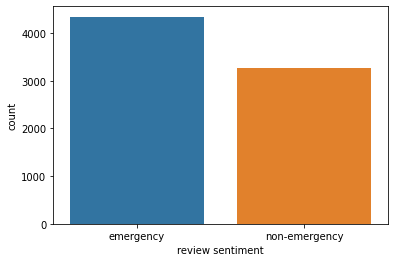

In [ ]:
def to_emergence(target):
  target = int(target)
  if target == 0 :
    return 0
  else:
    return 1

train_dir['sentiment'] = train_dir.target.apply(to_emergence)
class_names = ['emergency', 'non-emergency']
ax = sns.countplot(train_dir.target)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
#trying to count max token size
token_lens = []
for txt in train_dir.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


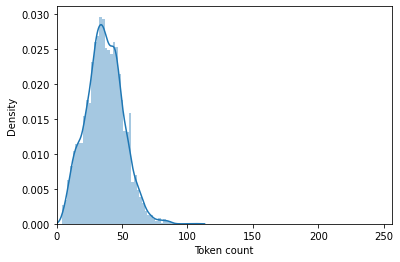

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
#most of the message seems to be lower than 100, we will take 128

In [ ]:
MAX_LEN = 128

In [ ]:
#pytorch dataset
class emergencyMsgDataset(Dataset):
  def __init__(self, text, target, tokenizer, max_len):
    self.text = text
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.text)
  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.target[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'message_text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
#train-test split
df_train, df_test = train_test_split(train_dir, test_size = 0.1, random_state = SEED)

df_train.shape, df_test.shape
#df_test.head()
# df_val, df_test = train_test_split(
#   df_test,
#   test_size=0.5,
#   random_state=RANDOM_SEED
# )
#df_val.shape, df_test.shape

((6851, 3), (762, 3))

In [ ]:
#dataloader creation
BATCH_SIZE = 16
def create_data_loader(df, train_dir, tokenizer, max_len, batch_size=BATCH_SIZE):
  ds = emergencyMsgDataset(
    text = df.text.to_numpy(),
    target = df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(ds, batch_size=batch_size, num_workers=2)

In [ ]:
train_data_loader

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
#val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
train_data_loader

In [ ]:
data = next(iter(train_data_loader))
data.keys()
dict_keys(['text', 'input_ids', 'attention_mask', 'target'])

AttributeError: ignored

In [ ]:
fields1 = [(None, None), ('text',TEXT),('target', LABEL)]
fields2 = [(None, None), ('text',TEXT)]

In [ ]:
#loading custom dataset
train_torch = data.TabularDataset(path = '/content/train_out.csv',format = 'csv',fields = fields1, skip_header = True)
# train,val = torchtext.data.TabularDataset.splits(path='./', train = "df.csv", validation = “val.csv”, format='csv', fields=data_fields, skip_header = True)
# train_torch, test_torch = data.TabularDataset.splits(path='/content/', 
#                                             format='csv', 
#                                             train='train_out.csv', 
#                                             test='test_out.csv', 
#                                             fields=fields,
#                                             skip_header=True)

test_torch = data.TabularDataset(path = '/content/test_out.csv',format = 'csv',fields = fields2, skip_header = True)
#print preprocessed text
print(vars(train_torch.examples[0]))

#print preprocessed text
print(vars(test_torch.examples[3]))

{'text': ['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all'], 'target': '1'}
{'text': ['Apocalypse', 'lighting', '.', '#', 'Spokane', '#', 'wildfires']}


In [ ]:
import random

train_data, valid_data = train_torch.split(random_state = random.seed(SEED))

In [ ]:
from torchtext.vocab import vocab

In [ ]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                          
100%|█████████▉| 398030/400000 [00:13<00:00, 28722.42it/s]

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
                                                (train_data, valid_data, test_torch), 
                                                batch_size = BATCH_SIZE,
                                                sort_within_batch = True,
                                                sort_key = lambda x: len(x.text),
                                                device = device)


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([20679, 100])


In [ ]:
emon = model.embedding.weight.data.copy_(pretrained_embeddings)
print(len(emon))

20679


In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6610, -0.0730,  0.9238,  ..., -0.2256,  0.8148, -0.4405],
        ...,
        [-1.2312,  0.6220, -0.6107,  ..., -0.2561,  0.4578, -1.0376],
        [ 0.3629, -0.1162,  0.6754,  ...,  0.9977,  0.0979,  0.3356],
        [-0.1975,  1.8562,  0.4219,  ...,  1.0809, -1.0475,  0.1038]])


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.target)
        
        acc = binary_accuracy(predictions, batch.target)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.target)
            
            acc = binary_accuracy(predictions, batch.target)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lab10-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.610 | Train Acc: 66.81%
	 Val. Loss: 0.537 |  Val. Acc: 74.10%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.526 | Train Acc: 74.96%
	 Val. Loss: 0.506 |  Val. Acc: 75.58%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.481 | Train Acc: 78.19%
	 Val. Loss: 0.505 |  Val. Acc: 77.26%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.422 | Train Acc: 81.72%
	 Val. Loss: 0.495 |  Val. Acc: 77.30%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.387 | Train Acc: 83.09%
	 Val. Loss: 0.523 |  Val. Acc: 78.14%


In [ ]:
def pred(iterator):
  
    
  p=[]
  model.eval()    
  with torch.no_grad():
    for batch in iterator:

      text, text_lengths = batch.text
      predictions = model(text, text_lengths).cpu()
      rp = torch.round(torch.sigmoid(predictions))
      #predicted_class = np.argmax(predictions)
      #predictions = model(text, text_lengths).squeeze(1).detach().cpu().numpy().argmax().item()
      #print(predictions)
      p.append(rp)
      #print(p)
            
  return p      

In [ ]:
import itertools
model.load_state_dict(torch.load('lab10-model.pt'))
predi= pred(test_iterator)
#print(predi)
print(type(predi))
print("length: ",len(predi))
#print(predi)

# tensor = [t.numpy() for t in predi]
#flatten_p = list(itertools.chain.from_iterable(predi))
#print("flat",flatten_p)
flatten_predictions = list(np.concatenate(predi).flat)
f_p = list(np.int_(flatten_predictions))
print("Flattened List ",f_p)
# print(type(flatten_p))
#print(len(flatten_p))
# arr = np.array(predictions)
# print(arr)

In [ ]:
test_csv = pd.read_csv("/content/test_out.csv")

test_csv['target'] = f_p
print(test_csv)

In [ ]:
test_csv.to_csv('output.csv')